In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we attempt solve following equation:

\begin{equation}
\partial_a\psi = i\kappa\frac{\nabla^2\psi}{a^3 \mathcal{H}}-i\frac{V\psi}{a^2\mathcal{H}}
\end{equation}
  
  where
  \begin{equation}
  \nabla^2V = \frac{1}{2\kappa}\left(|\psi|^2 -<|\psi|^2> \right)
  \end{equation}
with
\begin{equation}
\mathcal{H} = \sqrt{\Omega a^{-3} + (1-\Omega)}
\end{equation}

$a$ is scale-factor of the Universe and is monotonically increasing with physical time and is used in this code as 
time variable.
    
    
    
    
    

In [2]:
from GPE import GPE_scalar_field
from GPE import ImEx
import time

In [3]:
#3-d 
'''
# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imC = np.array([2.0/11,289.0/462.0,751.0/924.0])

exC= np.array([0.0,5.0/6.0,11.0/12.0])
imx = ImEx(3,Ahat,A,bhat,b,imC,exC)
'''
########################### scheme_Car4_3_6L_2_SA   #####################################

imA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.25,0.25,0.0,0.0,0.0,0.0],
[8611.0/62500.0,-1743.0/31250,0.25,0.0,0.0,0.0],
[5012029.0/34652500.0,-654441.0/2922500.0,174375.0/388108.0,0.25,0.0,0.0],
[15267082809.0/155376265600.0,-71443401.0/120774400.0, 730878875.0/902184768.0, 2285395.0/8070912.0,0.25,0.0],
[82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0, -2260.0/8211.0, 0.25]])

exA = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],
[0.5,0.0,0.0,0.0,0.0,0.0],
[13861.0/62500,  6889.0/62500.0,0.0,0.0,0.0,0.0],
[-116923316275.0/2393684061468.0, -2731218467317.0/15368042101831.0, 9408046702089.0/11113171139209.0, 0.0,0.0,0.0],
[-451086348788.0/2902428689909.0, -2682348792572.0/7519795681897.0, 12662868775082.0/11960479115383.0,3355817975965.0/11060851509271.0,0.0,0.0],
[647845179188.0/3216320057751.0,73281519250.0/8382639484533.0, 552539513391.0/3454668386233.0, 3354512671639.0/8306763924573.0,4040.0/17871.0,0.0]])

imb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])
exb = np.array([82889.0/524892.0, 0.0, 15625.0/83664.0, 69875.0/102672.0,-2260.0/8211.0,0.25])

imC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])
exC = np.array([0.0,0.5,83.0/250.0,31.0/50.0, 17.0/20.0,1.0])


imx = ImEx(6,imA,exA,imb,exb,imC,exC)

imx.cal_reg_of_stab()

def load_psi_hdf5(file_name,n,use_zeldo=1):
    f = h5.File(file_name,"r")
    keys = list(f.keys())
    if use_zeldo:
        psi = f["psi_zeldo"]
    else:
        psi = f["psi"]
        
    psi = psi[:,0]+1j*psi[:,1]
    psi = np.reshape(psi,(n,n,n))
        
    print("Psi shape",psi.shape,psi.dtype)
    
    return psi


def Hfunc(a,omega_m0,a0=1.0):
    return( np.sqrt(omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - omega_m0))    )


def rhs_f(u,xi2,kppa,a,da,s,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 1.5*omega_m0*(u2/np.mean(u2) -1.0)/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    
    
    ak = a+imx.ex_C[s]*da
    H = Hfunc(ak,omega_m0)
    
    
    return (-1j*v*u/(ak*ak*H))

def im_rhs(psi_ft,xi2,kppa,a,da,s,omega_m0):
   
    psi_ft = -psi_ft*(xi2)
    ak = a+imx.im_C[s]*da
    H = Hfunc(ak,omega_m0)
    return(1j*0.5*kppa*np.fft.ifftn(psi_ft,psi_ft.shape)/(ak*ak*ak*H))

    #return(0.0)

def calc_max_eig(u,xi2,kppa,a,omega_m0):
    
    u2 = np.square(np.abs(u))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape));
    H= Hfunc(a,omega_m0)
    mx = np.max(np.abs(v.real)/(a*a*H))
    
    return (mx)




      
class energy_constraint:
    def __init__(self):
        
        self.E=np.zeros([3])
        self.W=np.zeros([3])
        self.K=np.zeros([3])
        
        self.E_exp = 0.0
        self.E_ini = 0.0
        
        
    def calc_energy(self,u,xi3,xi2,kppa,a,da,n_cntr):
        ft_psi = np.fft.fftn(u,u.shape)
        ft_psi = 1j*xi3*ft_psi

        psi_x = np.fft.ifftn(ft_psi,ft_psi.shape[1:],axes=(1,2,3))
        psi_x = np.square(np.abs(psi_x)).sum(axis=0)

        Kv = 0.5*kppa*psi_x.sum()/(a*a)
     
    
        u2 = np.square(np.abs(u))
        vrhs = 0.5*(u2-np.mean(u2))/kppa
        vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
        vrhsft[0,0,0] = 0.0+0.0*1j
        v = (np.fft.ifftn(vrhsft,vrhsft.shape)).real;
    
        Wv = 0.5*np.sum(v*u2)/a
        
        Ev = Kv+Wv
        
       # print("Wv",Wv/Ev,"Kv",Kv/Ev)
        

    
        if(n_cntr==0):
            
            self.E[0] = Kv+Wv
            self.K[0] = Kv
            self.W[0] = Wv
            
            self.E_exp = 0.0
            self.E_ini = Ev
            dlta = 0.0
            dlta_intg=0.0
            
        if(n_cntr==1):
        
            self.E[1] = Kv+Wv
            self.K[1] = Kv
            self.W[1] = Wv
            
            dlta = 0.0
            dlta_intg=0.0
            
            

            
        
            
        
            
        if(n_cntr>1):
            
            if((n_cntr)%2==0):
                term_l = (2.0*self.K[0]+self.W[0])/(a-2.0*da)
                term_m = (2.0*self.K[1]+self.W[1])/(a-da)
                term_r = (2.0*Kv+Wv)/a
                self.E_exp+=(da/3.0)*(term_l+term_r+4.0*term_m)
                
            
            self.E[2] = Ev
            
            self.K[2] = Kv
            self.W[2] = Wv
            
            dE_da = (self.E[2]-self.E[0])/(2.0*da)
            rhs = -(2.0*self.K[1]+self.W[1])/(a-da)
            #rhs = self.W[1]/(a-da)
            
            dlta = dE_da/rhs-1.0
            
            #
            
            self.E[0] = self.E[1]
            self.K[0] = self.K[1]
            self.W[0] = self.W[1]
            
            self.E[1] = self.E[2]
            self.K[1] = self.K[2]
            self.W[1] = self.W[2]
            
            dlta_intg = (self.E_exp+Ev)/self.E_ini -1.0
            
            if(n_cntr==2):
                self.E_ini = (self.E_exp+Ev)
            
        #print("E_tot",self.E_exp+Ev,self.E_exp,Ev)
            
        return dlta,dlta_intg,Ev

        
    
        

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)



def solve_fdm_example(N,da):
    L = 1.0
    
    x = np.arange(-N/2,N/2)*(L/N)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(N)*N*2*np.pi/L
    xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    xi3 = np.array([xix,xiy,xiz])
    print("XI shape",xi3.shape)
    
    c_unit = 2.99
    hbar_unit = 6.582
    pc_unit = 3.086
    h = 0.67
    m_alpha = 0.175
    omega_m0 = 0.3
    ai = 0.0078125
    
    kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
    
   
   
    psi_ini = load_psi_hdf5("/Users/rajvanmp/station_X/pyGP_fields/test_fdm_dt/dc_128_dc_theta_psi_zeldo.hdf5",N,1)
   
    
   
    #psl = np.reshape(np.genfromtxt("test_initial1.txt",usecols=(4,5)),(N,N,N,2))
    #psi_ini = (psl[:,:,:,0]/100.0)+1j*(psl[:,:,:,1]/100.0)
    
    print(psi_ini.shape)
    
    

   
    print(type(psi_ini),psi_ini.shape,psi_ini.dtype)
    amax = 1.0

    

    num_plots = 50
    nplt = np.floor(((amax-ai)/num_plots)/da)
    if(nplt<1):
        nplt  = 1
    nmax = int(round((amax-ai)/da))
    print(nplt,"nmax",nmax)

    frames = [psi_ini.copy()]
    aa = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    eng_err_l = []
    

    
    
    psi = GPE_scalar_field(3,N,im_rhs,rhs_f,imx,psi_ini)
    
    energy_cond = energy_constraint()
    
    
    xi2 = (xix*xix+xiy*xiy+xiz*xiz)
    lmbda_s = (0.5*kppa*xi2)
    
    u2 = np.square(np.abs(psi_ini))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*omega_m0)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,omega_m0));
    
    mass = psi.calc_mass()
    
    max_err = -1.0
    a = ai
    start_time = time.time()  
   
    for n in range(nmax):
        
        eng_dlta,eng_dlta_intg,Ev = energy_cond.calc_energy(psi.psi,xi3,xi2,kppa,a,da,n)
        #print(n)
        for k in range(imx.s):
            ak = a+imx.im_C[k]*da
            Hk = Hfunc(ak,omega_m0)
            lmbda = lmbda_s/(ak*ak*ak*Hk)
            
            psi.update_stage_sum(k,da)
            psi.do_fft(k,lmbda,da)
            psi.update_K(k,xi2,kppa,a,da,k,omega_m0)
            
            #max_egn = calc_max_eig(psi.psi,xi2,kppa,a,omega_m0)
            #print("maxeg*dt @ n",max_egn*da,n,k,imx.r_of_stb.imag)
        psi_tmp = psi.psi*1.0   
        psi.sum_contributions(da)
        
        
        a = ai+(n+1)*da
        
        max_egn = calc_max_eig(psi.psi,xi2,kppa,a,omega_m0)
        
        
        
        if((max_egn*da)>imx.r_of_stb.imag):
            print("maxeg*dt @ n",max_egn*da,n,k,imx.r_of_stb.imag)
            da  = 0.9*(imx.r_of_stb.imag/max_egn)
        
        
        
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            aa.append(a)
           # err = sol_err(psi.psi,t,nx,T,max_err)
          #  err_l.append(err)
            print(np.abs(mass-psi.mass_ini)/psi.mass_ini)
            print(a,da,eng_dlta,eng_dlta_intg)
            
            mass = np.sum(np.square(np.abs(psi.psi)))#psi.calc_mass()
            mass_err = np.abs((mass-psi.mass_ini))/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            eng_err_l.append([eng_dlta,eng_dlta_intg])
            
            


   # err =  sol_err(psi.psi,t,nx,T,max_err)
  #  err_l.append(err)
            
    mass = np.sum(np.square(np.abs(psi.psi)))
    mass_err = np.abs((mass-psi.mass_ini))/psi.mass_ini
    #eng_dlta = energy_cond.calc_energy(psi.psi,xi3,xi2,kppa,a,da,n)
    
    print("LAST",mass_err,eng_dlta)
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames,mass_l,mass_err_l,eng_err_l,(time.time() - start_time)

In [4]:
da = 0.001
er = []
dal = []
for i in range(1):
        print(i)
        frames,mass_l,mass_err_l,eng_er_l,comp_time = solve_fdm_example(128,da)
        
        er.append(np.max(np.abs(mass_err_l)))
        dal.append(da)
        
        da = 0.5*da
        
        

er = np.array(er)
dal = np.array(dal)

ldt = np.log(dal)
lerrmx = np.log(er)


z= np.polyfit(ldt,lerrmx,1)

#print(z)

0
XI shape (3, 128, 128, 128)
Psi shape (128, 128, 128) complex128
(128, 128, 128)
<class 'numpy.ndarray'> (128, 128, 128) complex128
19.0 nmax 992
class shapes (128, 128, 128) (6, 128, 128, 128)
(128, 128, 128) (128, 128, 128)


/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:285: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:285: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:124: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:124: RuntimeWarning: invalid value encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:65: RuntimeWarning: divide by zero encountered in divide
  vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
/var/folders/ll/kxnszbbj3b1bqwnlk_bqpjl8ffbpq7/T/ipykernel_66183/2991292739.py:65: RuntimeWar

[0.]
0.008812500000000001 0.001 0.0 0.0
0.0009055182500624113
0.0278125 0.001 -0.009592452202581758 -0.02209301276935849
0.0009572773760909609
0.0468125 0.001 -0.002055117652233762 -0.01971698825851398
0.0009562091646837693
0.0658125 0.001 -0.0036689554978917016 -0.02007224729116408
0.0009561565505447674
0.0848125 0.001 -0.00470387801703831 -0.019659214897981947
0.000956150252545637
0.1038125 0.001 -0.0052353567001259815 -0.01992785659857721
0.0009561494203618419
0.1228125 0.001 -0.005522431301648867 -0.019599385506410383
0.0009561500215152056
0.1418125 0.001 -0.005697310441408199 -0.01986864483934292
0.0009561518244402879
0.1608125 0.001 -0.005823556282254283 -0.019533824223879948
0.00095615567958965
0.17981250000000001 0.001 -0.005933711313526935 -0.019826629086894365
0.0009561637769289191
0.1988125 0.001 -0.00604611088382534 -0.019459220093428375
0.0009561813631450707
0.2178125 0.001 -0.006168351394519989 -0.019793472841476367
0.0009562226773010452
0.2368125 0.001 -0.006288425579431

/Users/Shared/my_installs/anaconda3/envs/k@ust/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
        

er = np.array(er)
dal = np.array(dal)

ldt = np.log(dal)
lerrmx = np.log(er)


z= np.polyfit(ldt,lerrmx,1)
print(er,z)

[0.01137785 0.00152138] [ 2.90277853 15.57559682]


In [5]:
with open('imex4O_psi_0p5m4.npy', 'wb') as f:
    np.save(f,frames[-1])

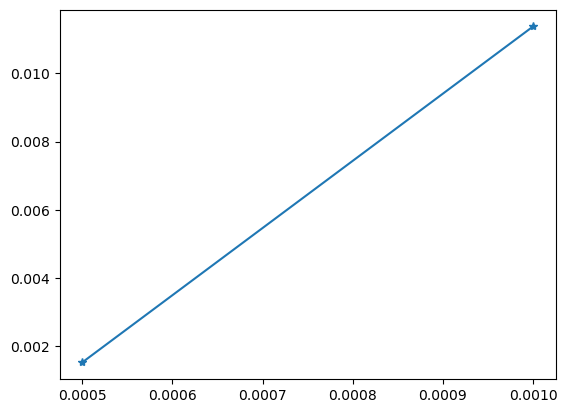

In [8]:
plt.plot(dal,er,"*-")

In [10]:
dal

array([0.001 , 0.0005])

In [86]:
er9 = np.array([0.010032908622657452,0.008318895463512969,0.0058032856589819125,0.003759421933143914])
dal = np.array([0.02,0.016,0.0128,0.01024])


zl =  np.polyfit(dal,er9,1)
print(z,zl)

[1.48107407 0.54666867] [ 0.64806944 -0.00258688]


In [72]:
er = [0.011023150021712851,0.003329787928342017,0.0016355046529647603,0.0013103337915628308,0.0011128141757339501]

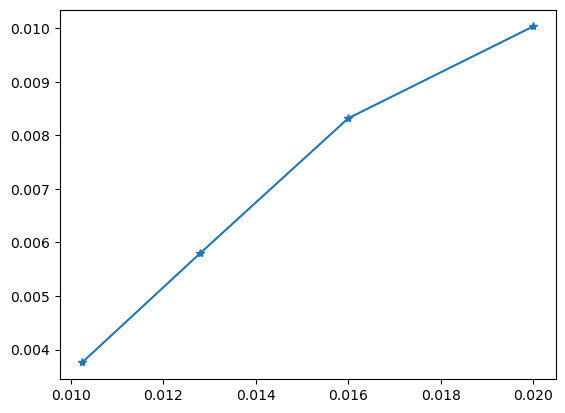

In [87]:
plt.plot(dal,er9,"*-")

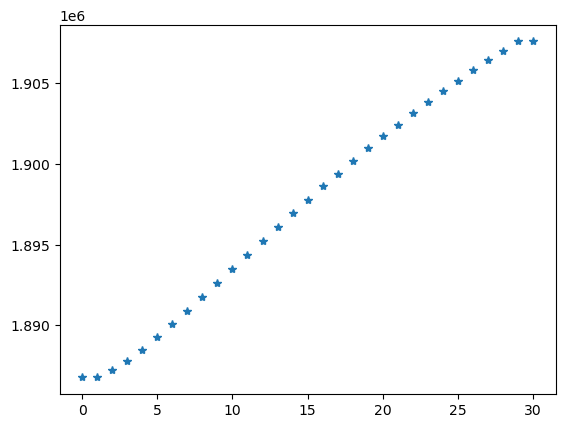

In [40]:
plt.plot(mass_l,"*")

In [41]:
mass_l

[array([1886784.6361173]),
 array([1886843.78919322]),
 array([1887243.41215242]),
 array([1887823.45518898]),
 array([1888509.97960656]),
 array([1889265.37208902]),
 array([1890067.48562509]),
 array([1890901.44116947]),
 array([1891756.30405306]),
 array([1892623.39854029]),
 array([1893495.7229874]),
 array([1894367.63733073]),
 array([1895234.67116943]),
 array([1896093.11482021]),
 array([1896940.18067787]),
 array([1897773.54353581]),
 array([1898591.46966142]),
 array([1899392.677979]),
 array([1900176.17055637]),
 array([1900941.26301838]),
 array([1901687.52878239]),
 array([1902414.701145]),
 array([1903122.68048835]),
 array([1903811.49066329]),
 array([1904481.26859139]),
 array([1905132.21630296]),
 array([1905764.61709718]),
 array([1906378.79113998]),
 array([1906975.10096985]),
 array([1907553.94222865]),
 array([1907553.94222865])]

In [20]:
0.02424803020672399/0.0050444183570501145

4.8069030937600115

In [117]:
ai = 0.0078125
omega_m0 = 0.3
c_unit = 2.99
hbar_unit = 6.582
pc_unit = 3.086
h = 0.67
m_alpha = 0.175
omega_m0 = 0.3
ai = 0.0078125
    
kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
print(0.5*kppa/(ai*ai*ai*Hfunc(ai,omega_m0)))

0.9650841359308788


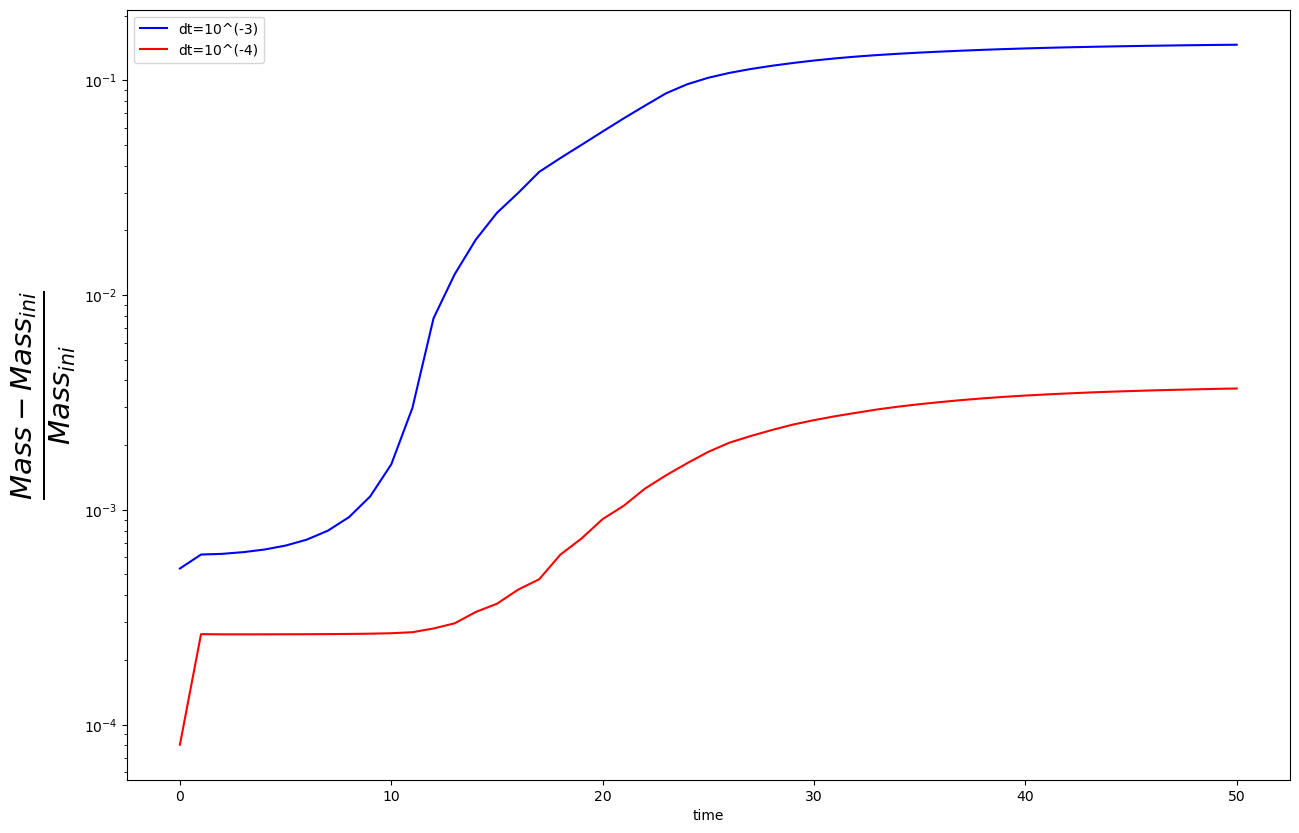

In [26]:
fig = plt.figure(figsize=(15,10))
plt.yscale("log")
plt.xlabel("time")
plt.ylabel(r"$\frac{Mass-Mass_{ini}}{Mass_{ini}}$",fontsize=30)
plt.plot(np.abs(mass_err_l2),"b",label = "dt=10^(-3)")
plt.plot(np.abs(mass_err_l),"r",label = "dt=10^(-4)")
plt.legend(loc="best")
fig.savefig("fdm_test.pdf")

In [ ]:
f = h5.File('test_psi_da1p25m4.h5', 'w')

d = f.create_dataset("psi_frames",data = np.array(frames))
d = f.create_dataset("mass_err",data=np.array(mass_err_l))
d = f.create_dataset("compute_time",data = comp_time)
d = f.create_dataset("da",data=(np.array(da)))


    
f.close()
print(comp_time)

In [15]:
#with open('test_data_m3.npy', 'wb') as f2:
#    np.save(f2,np.array(frames2))

In [38]:
dta.dtype

dtype('complex128')

In [39]:
dta.shape

(51, 128, 128, 128)

In [18]:
d2 = d2/10000.0

In [19]:
dlt = d2.flatten()/(3.0*0.3)-1.0

In [20]:
dlt.shape

(2097152,)

In [21]:
dlt.sum()

-4.3141312744410243e-10

In [22]:
d.real

array([[103.02049518,  -1.25228466],
       [ 98.86225297,  -1.17613939],
       [ 96.26808953,  -1.12063124],
       ...,
       [103.57740649,  -1.60874772],
       [108.51031287,  -1.53114843],
       [108.00033975,  -1.42282909]])